<a href="https://colab.research.google.com/github/ArfianAl/Bullience-ML-Bangkit-Team/blob/main/Klasifikasi_Bully_Model_Revisi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
import tensorflow as tf
import matplotlib as mpl
from cycler import cycler
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.linestyle'] = '--'
import re
import string
import nltk
nltk.download('stopwords')
sns.despine()
plt.style.use("fivethirtyeight")
sns.set_style("darkgrid")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


<Figure size 640x480 with 0 Axes>

In [ ]:
pip install openpyxl

# **READ DATASET**

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
ds= pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Datasets/DATASETS GABUNGAN BULLIENCE.csv")
ds

,id,teks,label
0,1,"Kaka tidur yaa, udah pagi, gaboleh capek2",Non-bullying
1,2,makan nasi padang aja begini badannya,Non-bullying
2,3,yang aku suka dari dia adalah selalu cukur jem...,Bullying
3,4,Hai kak Isyana aku ngefans banget sama kak Isy...,Non-bullying
4,5,Manusia apa bidadari sih herann deh cantik ter...,Non-bullying
...,...,...,...
1045,1046,Bangga sama suami yg selalu ingat istri disela...,Non-bullying
1046,1047,Apaoun pekerjaannya yg penting halal u tuk men...,Non-bullying
1047,1048,Gojek itu mayoritas pegangguran yang lama gak ...,Non-bullying
1048,1049,<USERNAME> aslinya cantik dan ayu loh mbak krn...,Non-bullying


# **DATA PREPROCESSING**

In [ ]:
#info dataset
ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1050 non-null   int64 
 1   teks    1050 non-null   object
 2   label   1050 non-null   object
dtypes: int64(1), object(2)
memory usage: 24.7+ KB


In [ ]:
# Checking for null values
ds.isnull().values.any()

False

In [ ]:
# Melihat jumlah masing-masing tipe
ds['label'].value_counts()

Non-bullying    525
Bullying        525
Name: label, dtype: int64

Counter({'Non-bullying': 525, 'Bullying': 525})


<Axes: xlabel='label', ylabel='count'>

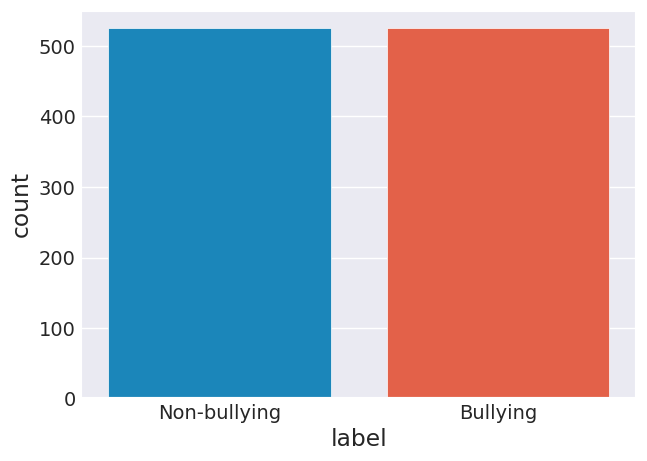

In [ ]:
# Distribusi Target
x = ds.teks
y = ds.label

from collections import Counter

print(Counter(y))
sns.countplot(x=y)

count    525.000000
mean      15.417143
std       12.487982
min        3.000000
25%        8.000000
50%       12.000000
75%       18.000000
max      152.000000
Name: Length, dtype: float64

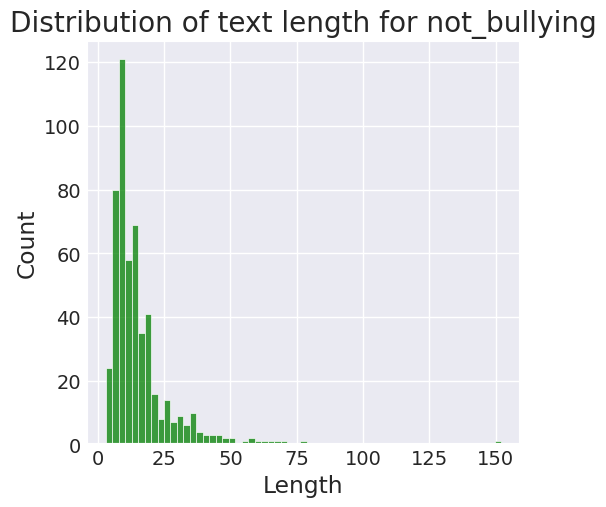

In [ ]:
# Melihat statistical description serta histogram panjang teks Non-B
ds["Length"] = ds.teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(ds[ds["label"]=="Non-bullying"]['Length'],color="g")
plt.title("Distribution of text length for not_bullying")
display(ds.Length[ds["label"]=="Non-bullying"].describe())

count    525.000000
mean      15.676190
std       13.125128
min        2.000000
25%        7.000000
50%       10.000000
75%       19.000000
max       73.000000
Name: Length, dtype: float64

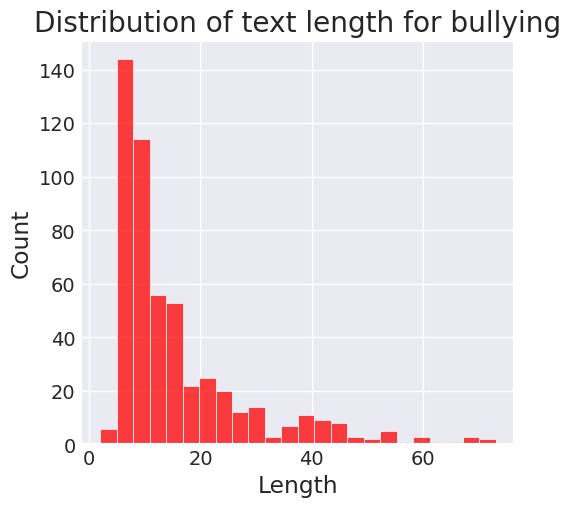

In [ ]:
# Melihat statistical description serta histogram panjang teks B
ds["Length"] = ds.teks.str.split().apply(len)
plt.figure(figsize=(5,5))
sns.histplot(ds[ds["label"]=="Bullying"]['Length'],color="r")
plt.title("Distribution of text length for bullying")
display(ds.Length[ds["label"]=="Bullying"].describe())

In [ ]:
# variabel untuk kolom teks
texts = ds.teks
print(texts.head())

0            Kaka tidur yaa, udah pagi, gaboleh capek2
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    Hai kak Isyana aku ngefans banget sama kak Isy...
4    Manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object


In [ ]:
# Case Folding
# gunakan fungsi series.str.lower() pada Pandas
texts = texts.str.lower()

print(texts.head())

0            kaka tidur yaa, udah pagi, gaboleh capek2
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object


In [ ]:
def remove_special_signs(text):
    # remove tab, new line, ans back slice
    text = text.replace('\\t'," ").replace('\\n'," ").replace('\\u'," ").replace('\\',"")
    # remove non ASCII (emoticon, chinese word, .etc)
    text = text.encode('ascii', 'replace').decode('ascii')
    # remove mention, link, hashtag
    text = ' '.join(re.sub("([@#][A-Za-z0-9]+)|(\w+:\/\/\S+)"," ", text).split())
    # remove incomplete URL
    return text.replace("http://", " ").replace("https://", " ")

texts = texts.apply(remove_special_signs)
print(texts.head())

0            kaka tidur yaa, udah pagi, gaboleh capek2
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object


In [ ]:
#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

texts = texts.apply(remove_number)
texts.head(5)

0             kaka tidur yaa, udah pagi, gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik ter...
Name: teks, dtype: object

In [ ]:
# remove punctuation
def remove_punctuation(text):
    return text.translate(str.maketrans("","",string.punctuation))

texts = texts.apply(remove_punctuation)
texts.head(5)

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4    manusia apa bidadari sih herann deh cantik terus 
Name: teks, dtype: object

In [ ]:
#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

texts = texts.apply(remove_whitespace_LT)
print(texts.head())

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4     manusia apa bidadari sih herann deh cantik terus
Name: teks, dtype: object


In [ ]:
# remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)

texts = texts.apply(remove_whitespace_multiple)
print(texts.head())

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4     manusia apa bidadari sih herann deh cantik terus
Name: teks, dtype: object


In [ ]:
# remove single char
def remove_singl_char(text):
    return re.sub(r"\b[a-zA-Z]\b", "", text)

texts = texts.apply(remove_singl_char)
print(texts.head())

0               kaka tidur yaa udah pagi gaboleh capek
1                makan nasi padang aja begini badannya
2    yang aku suka dari dia adalah selalu cukur jem...
3    hai kak isyana aku ngefans banget sama kak isy...
4     manusia apa bidadari sih herann deh cantik terus
Name: teks, dtype: object


In [ ]:
# Filtering - Stopword Removal
from nltk.corpus import stopwords
# Get Indonesian stopwords
list_stopwords = stopwords.words('indonesian')

# append additional stopword
list_stopwords.extend(["yg", "dg", "rt", "dgn", "ny", "d", 'klo',
                       'kalo', 'amp', 'biar', 'bikin', 'bilang',
                       'gak', 'ga', 'krn', 'nya', 'nih', 'sih',
                       'si', 'tau', 'tdk', 'tuh', 'utk', 'ya',
                       'jd', 'jgn', 'sdh', 'aja',
                       'nyg', 'hehe', 'pen', 'nan', 'loh',
                       '&amp', 'yah',])

# read txt stopword using pandas
csv_stopword = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Datasets/stopwordsID.csv")

# convert stopword string to list & append additional stopword
list_stopwords.extend(csv_stopword)

# convert list to dictionary
list_stopwords = set(list_stopwords)

#remove stopword pada list token
def stopwords_removal(words):
    return [word for word in words if word not in list_stopwords]

texts = texts.apply(stopwords_removal)


print(texts.head())

0    [k, a, k, a,  , t, i, u, r,  , y, a, a,  , u, ...
1    [m, a, k, a, n,  , n, a, s, i,  , p, a, a, n, ...
2    [y, a, n, g,  , a, k, u,  , s, u, k, a,  , a, ...
3    [h, a, i,  , k, a, k,  , i, s, y, a, n, a,  , ...
4    [m, a, n, u, s, i, a,  , a, p, a,  , b, i, a, ...
Name: teks, dtype: object


In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('indonesian'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

ds['teks'] = ds['teks'].apply(normalize_text)

In [ ]:
# Normalisasi
normalized_word = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/Datasets/kamus_singkatan.csv")

normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1]

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

texts = texts.apply(normalized_term)

texts.head(10)

0    [k, a, k, a,  , t, i, u, r,  , y, a, a,  , u, ...
1    [m, a, k, a, n,  , n, a, s, i,  , p, a, a, n, ...
2    [y, a, n, g,  , a, k, u,  , s, u, k, a,  , a, ...
3    [h, a, i,  , k, a, k,  , i, s, y, a, n, a,  , ...
4    [m, a, n, u, s, i, a,  , a, p, a,  , b, i, a, ...
5    [k, i, n, a, n, t, i, i,  , i, s, y, a, n,  , ...
6    [g, e, m, e, s, n, y, a,  , i, s, y, a, n,  , ...
7    [m, a, k, i, n,  , j, e, l, e, k,  , a, j, a, ...
8    [k, o, k,  , a, n, a, k, n, y, a,  , k, a, y, ...
9    [m, u, k, a,  , a, n, a, k,  , n, y, a,  , k, ...
Name: teks, dtype: object

In [ ]:
!pip install Sastrawi
!pip install Swifter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for Swifter: filename=swifter-1.4.0-py3-none-any.whl size=16506 sha256=834d0635de339de897d26670dfc653a369d90f45562c420720b188ca17370b75
  Stored in directory: /root/.cache/pip/wheels/e4/cf/51/0904952972ee2c7aa3709437065278dc534ec1b8d2ad41b443
Successfully built Swifter


In [ ]:
# convert the categorical values to numeric using the factorize() method. This returns an array of numeric values and an Index of categories.
# Inisialisasi variabel target
y = ds["label"]
#mengubah y menjadi integer
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)
print(y)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [ ]:
# Menghitung jumlah value integer sentimen
ds["label"].value_counts()

Non-bullying    525
Bullying        525
Name: label, dtype: int64

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def normalize_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

ds['teks'] = ds['teks'].apply(normalize_text)

In [ ]:
# Tokenisasi dan stemming
def tokenize_and_stem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    stemmer = PorterStemmer()
    stems = [stemmer.stem(t) for t in tokens]
    return stems

# Contoh pemisahan dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(ds['teks'], ds['label'], test_size=0.2, random_state=42)

# Representasi vektor menggunakan CountVectorizer
vectorizer = CountVectorizer(tokenizer=tokenize_and_stem, max_features=5000)
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Transformasi TF-IDF
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Encoding label kategori menggunakan LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


# **BUILD MODEL**

In [ ]:

#untuk menentukan size untuk proses embedding, kalimat input sequence huruf akan diubah menjadi word embedding.
#definisi word embedding menyusul
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(512, input_shape=(3549,), activation='relu'),
    tf.keras.layers.Dropout(0.5),
    #tf.keras.layers.Conv1D(64, 5, activation='relu'),
    #tf.keras.layers.MaxPooling1D(pool_size=4),
    #tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')

])
# #layer embedding
# model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
# #Yang digunakan adalah CNN 1-dimensi
# model.add(tf.keras.layers.Conv1D(32,2,activation="relu"))
# model.add(tf.keras.layers.MaxPooling1D(5))
# #32 adalah filter, 8 unit convolution,
# #setelah convolution, pasti ada max pooling, max pooling 1 dimension
# model.add(MaxPooling1D(2,2))
# #Dropout adalah bentuk konfigurasi supaya tidak overfitting
# model.add(Dropout(0.2))
# model.add(Dense(64, activation = "relu"))
# model.add(Dropout(0.5))
# model.add(MaxPooling1D(2,2))
# #model LSTM
# #layer utk mengubah sequence index kata menjadi vektor
# model.add(LSTM(100, dropout=0.5, recurrent_dropout=0.5))
# model.add(Dropout(0.2))
# #layer klasifikasi akhir
# model.add(Dense(2, activation='softmax'))
# #Compile Model
#model.compile(loss='binary_crossentropy',optimizer='sgd', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy',optimizer='rmsprop', metrics=['accuracy'])
# model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               1817600   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1949185 (7.44 MB)
Trainable params: 1949185 (7.44 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [ ]:
model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
24/24 [==============================] - 2s 51ms/step - loss: 0.6882 - accuracy: 0.5304 - val_loss: 0.6809 - val_accuracy: 0.5714
Epoch 2/10
24/24 [==============================] - 1s 35ms/step - loss: 0.6097 - accuracy: 0.8823 - val_loss: 0.5719 - val_accuracy: 0.8571
Epoch 3/10
24/24 [==============================] - 1s 39ms/step - loss: 0.2994 - accuracy: 0.9616 - val_loss: 0.4468 - val_accuracy: 0.8452
Epoch 4/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0716 - accuracy: 0.9815 - val_loss: 0.4542 - val_accuracy: 0.8214
Epoch 5/10
24/24 [==============================] - 1s 36ms/step - loss: 0.0143 - accuracy: 0.9987 - val_loss: 0.4756 - val_accuracy: 0.8214
Epoch 6/10
24/24 [==============================] - 1s 39ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.5183 - val_accuracy: 0.8333
Epoch 7/10
24/24 [==============================] - 1s 38ms/step - loss: 0.0027 - accuracy: 1.0000 - val_loss: 0.5332 - val_accuracy: 0.8333
Epoch 8/10
24

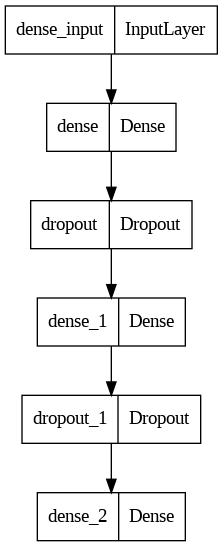

In [ ]:
#Plotting model
plot_model(model)

In [ ]:
history = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=10, batch_size=32, validation_split=0.1)

Epoch 1/10
24/24 [==============================] - 1s 28ms/step - loss: 6.5210e-04 - accuracy: 1.0000 - val_loss: 0.5598 - val_accuracy: 0.8333
Epoch 2/10
24/24 [==============================] - 1s 27ms/step - loss: 5.8334e-04 - accuracy: 1.0000 - val_loss: 0.5686 - val_accuracy: 0.8333
Epoch 3/10
24/24 [==============================] - 1s 36ms/step - loss: 4.8752e-04 - accuracy: 1.0000 - val_loss: 0.5809 - val_accuracy: 0.8333
Epoch 4/10
24/24 [==============================] - 1s 39ms/step - loss: 4.4041e-04 - accuracy: 1.0000 - val_loss: 0.5988 - val_accuracy: 0.8333
Epoch 5/10
24/24 [==============================] - 1s 37ms/step - loss: 4.0711e-04 - accuracy: 1.0000 - val_loss: 0.6056 - val_accuracy: 0.8333
Epoch 6/10
24/24 [==============================] - 1s 37ms/step - loss: 3.0449e-04 - accuracy: 1.0000 - val_loss: 0.6248 - val_accuracy: 0.8333
Epoch 7/10
24/24 [==============================] - 1s 62ms/step - loss: 2.8608e-04 - accuracy: 1.0000 - val_loss: 0.6277 - val_ac

In [ ]:
hist = model.fit(X_train_tfidf.toarray(), y_train_encoded, epochs=20, batch_size=32, validation_split=0.1)

Epoch 1/20
24/24 [==============================] - 1s 51ms/step - loss: 1.8837e-04 - accuracy: 1.0000 - val_loss: 0.6380 - val_accuracy: 0.8333
Epoch 2/20
24/24 [==============================] - 1s 47ms/step - loss: 1.9508e-04 - accuracy: 1.0000 - val_loss: 0.6438 - val_accuracy: 0.8333
Epoch 3/20
24/24 [==============================] - 1s 53ms/step - loss: 1.4814e-04 - accuracy: 1.0000 - val_loss: 0.6531 - val_accuracy: 0.8333
Epoch 4/20
24/24 [==============================] - 1s 62ms/step - loss: 1.4609e-04 - accuracy: 1.0000 - val_loss: 0.6581 - val_accuracy: 0.8333
Epoch 5/20
24/24 [==============================] - 1s 40ms/step - loss: 1.8865e-04 - accuracy: 1.0000 - val_loss: 0.6711 - val_accuracy: 0.8333
Epoch 6/20
24/24 [==============================] - 1s 36ms/step - loss: 1.4303e-04 - accuracy: 1.0000 - val_loss: 0.6781 - val_accuracy: 0.8214
Epoch 7/20
24/24 [==============================] - 1s 35ms/step - loss: 8.8642e-05 - accuracy: 1.0000 - val_loss: 0.6799 - val_ac

In [ ]:
loss, accuracy = model.evaluate(X_test_tfidf.toarray(), y_test_encoded)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

7/7 [==============================] - 0s 13ms/step - loss: 0.5523 - accuracy: 0.8476
Test Loss: 0.552330732345581, Test Accuracy: 0.8476190567016602


In [ ]:
predictions = model.predict(X_test_tfidf.toarray())

7/7 [==============================] - 1s 21ms/step


In [ ]:
predicted_labels = label_encoder.inverse_transform((predictions > 0.5).astype('int').ravel())

In [ ]:
model.save('Model_Bully.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
hist = model.fit(x_train, y_train, epochs=30, validation_data=(x_test, y_test), verbose = 1)

Epoch 1/30
17/17 [==============================] - 3s 176ms/step - loss: 0.6938 - accuracy: 0.5048 - val_loss: 0.6933 - val_accuracy: 0.5010
Epoch 2/30
17/17 [==============================] - 5s 285ms/step - loss: 0.6933 - accuracy: 0.4667 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 3/30
17/17 [==============================] - 3s 168ms/step - loss: 0.6935 - accuracy: 0.4838 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 4/30
17/17 [==============================] - 3s 152ms/step - loss: 0.6936 - accuracy: 0.4762 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 5/30
17/17 [==============================] - 3s 152ms/step - loss: 0.6932 - accuracy: 0.4971 - val_loss: 0.6931 - val_accuracy: 0.4990
Epoch 6/30
17/17 [==============================] - 3s 151ms/step - loss: 0.6932 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.5010
Epoch 7/30
17/17 [==============================] - 4s 246ms/step - loss: 0.6932 - accuracy: 0.5010 - val_loss: 0.6932 - val_accuracy: 0.4990
Epoch 

In [ ]:
hist = model.fit(x_train, y_train, epochs=40, validation_data=(x_test, y_test), verbose = 2)

Epoch 1/40
17/17 - 0s - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.5010 - 207ms/epoch - 12ms/step
Epoch 2/40
17/17 - 0s - loss: 0.6931 - accuracy: 0.5200 - val_loss: 0.6931 - val_accuracy: 0.5010 - 143ms/epoch - 8ms/step
Epoch 3/40
17/17 - 0s - loss: 0.6931 - accuracy: 0.5124 - val_loss: 0.6931 - val_accuracy: 0.5010 - 174ms/epoch - 10ms/step
Epoch 4/40
17/17 - 0s - loss: 0.6933 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.5010 - 156ms/epoch - 9ms/step
Epoch 5/40
17/17 - 0s - loss: 0.6932 - accuracy: 0.5048 - val_loss: 0.6931 - val_accuracy: 0.5010 - 173ms/epoch - 10ms/step
Epoch 6/40
17/17 - 0s - loss: 0.6932 - accuracy: 0.4781 - val_loss: 0.6931 - val_accuracy: 0.5010 - 172ms/epoch - 10ms/step
Epoch 7/40
17/17 - 0s - loss: 0.6931 - accuracy: 0.5219 - val_loss: 0.6931 - val_accuracy: 0.5010 - 173ms/epoch - 10ms/step
Epoch 8/40
17/17 - 0s - loss: 0.6930 - accuracy: 0.5086 - val_loss: 0.6931 - val_accuracy: 0.5010 - 167ms/epoch - 10ms/step
Epoch 9/40

In [ ]:
hist = model.fit(x_train, y_train, epochs=50, validation_data=(x_test, y_test), verbose = 2)

Epoch 1/50
17/17 - 0s - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5010 - 290ms/epoch - 17ms/step
Epoch 2/50
17/17 - 0s - loss: 0.6932 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.5010 - 251ms/epoch - 15ms/step
Epoch 3/50
17/17 - 0s - loss: 0.6932 - accuracy: 0.4914 - val_loss: 0.6931 - val_accuracy: 0.5010 - 386ms/epoch - 23ms/step
Epoch 4/50
17/17 - 0s - loss: 0.6931 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.5010 - 481ms/epoch - 28ms/step
Epoch 5/50
17/17 - 1s - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5010 - 506ms/epoch - 30ms/step
Epoch 6/50
17/17 - 0s - loss: 0.6931 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5010 - 441ms/epoch - 26ms/step
Epoch 7/50
17/17 - 0s - loss: 0.6933 - accuracy: 0.4952 - val_loss: 0.6931 - val_accuracy: 0.5010 - 466ms/epoch - 27ms/step
Epoch 8/50
17/17 - 0s - loss: 0.6932 - accuracy: 0.4800 - val_loss: 0.6931 - val_accuracy: 0.5010 - 416ms/epoch - 24ms/step
Epoch 9/

In [ ]:
hist = model.fit(x_train, y_train, epochs=60, validation_data=(x_test, y_test), shuffle=True, verbose = 2)

Epoch 1/60
17/17 - 1s - loss: 0.6932 - accuracy: 0.4933 - val_loss: 0.6931 - val_accuracy: 0.5010 - 566ms/epoch - 33ms/step
Epoch 2/60
17/17 - 0s - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5010 - 481ms/epoch - 28ms/step
Epoch 3/60
17/17 - 0s - loss: 0.6932 - accuracy: 0.4895 - val_loss: 0.6931 - val_accuracy: 0.4990 - 433ms/epoch - 25ms/step
Epoch 4/60
17/17 - 0s - loss: 0.6933 - accuracy: 0.4857 - val_loss: 0.6931 - val_accuracy: 0.5010 - 406ms/epoch - 24ms/step
Epoch 5/60
17/17 - 0s - loss: 0.6934 - accuracy: 0.4514 - val_loss: 0.6932 - val_accuracy: 0.4990 - 475ms/epoch - 28ms/step
Epoch 6/60
17/17 - 0s - loss: 0.6932 - accuracy: 0.4819 - val_loss: 0.6931 - val_accuracy: 0.4990 - 423ms/epoch - 25ms/step
Epoch 7/60
17/17 - 0s - loss: 0.6931 - accuracy: 0.5143 - val_loss: 0.6931 - val_accuracy: 0.4990 - 479ms/epoch - 28ms/step
Epoch 8/60
17/17 - 0s - loss: 0.6931 - accuracy: 0.5105 - val_loss: 0.6932 - val_accuracy: 0.4990 - 464ms/epoch - 27ms/step
Epoch 9/

In [ ]:
hist = model.fit(x_train, y_train, epochs=70, validation_data=(x_test, y_test), verbose = 2)

Epoch 1/70
17/17 - 1s - loss: 0.6931 - accuracy: 0.5162 - val_loss: 0.6932 - val_accuracy: 0.4990 - 612ms/epoch - 36ms/step
Epoch 2/70
17/17 - 0s - loss: 0.6936 - accuracy: 0.4362 - val_loss: 0.6932 - val_accuracy: 0.4990 - 276ms/epoch - 16ms/step
Epoch 3/70
17/17 - 0s - loss: 0.6932 - accuracy: 0.5029 - val_loss: 0.6931 - val_accuracy: 0.5010 - 292ms/epoch - 17ms/step
Epoch 4/70
17/17 - 0s - loss: 0.6930 - accuracy: 0.5124 - val_loss: 0.6931 - val_accuracy: 0.5010 - 293ms/epoch - 17ms/step
Epoch 5/70
17/17 - 0s - loss: 0.6934 - accuracy: 0.4781 - val_loss: 0.6932 - val_accuracy: 0.4990 - 262ms/epoch - 15ms/step
Epoch 6/70
17/17 - 0s - loss: 0.6934 - accuracy: 0.5048 - val_loss: 0.6932 - val_accuracy: 0.4990 - 281ms/epoch - 17ms/step
Epoch 7/70
17/17 - 0s - loss: 0.6931 - accuracy: 0.4838 - val_loss: 0.6932 - val_accuracy: 0.4990 - 267ms/epoch - 16ms/step
Epoch 8/70
17/17 - 0s - loss: 0.6929 - accuracy: 0.5295 - val_loss: 0.6932 - val_accuracy: 0.4990 - 298ms/epoch - 18ms/step
Epoch 9/

In [ ]:
#Plot training validation accuracy and loss
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.style.use(['seaborn-whitegrid'])
mpl.rcParams['axes.prop_cycle'] = cycler(color=['r', 'b'])
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: ignored

In [ ]:
# Akurasi model
accuracy = model.evaluate(x_test, y_test)
print("Accuracy of the model is: ", accuracy)

NameError: ignored

In [ ]:
#Evaluasi
print("Model Performance of CNN (Test Accuracy)")
print('Accuracy: {:0.2f}%\nLoss: {:0.2f}%\n'.format(accuracy[1]*100, accuracy[0]))

Model Performance of CNN (Test Accuracy)


NameError: ignored

In [ ]:
model.save('model_bully.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
